# Предсказание заказов такси на следующий час

Имеются синтетические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Целью данного проекта является создание модели для такого предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## 1. Загрузка, анализ и обработка данных

В начале импортируем необходимые в дальнейшей работе библиотеки:

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
#!pip install lightgbm
from lightgbm import LGBMRegressor

Загрузим набор данных, сразу переведя временные данные в нужный тип и воспользовавшись ими в качестве индекса:

In [2]:
try:
    taxis = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxis = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Проверим, располагаются ли данные в хронологическом порядке:

In [3]:
taxis.index.is_monotonic

True

Все в порядке - данные идут по порядку. Взглянем на получившийся датафрейм:

In [4]:
taxis.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


Согласно цели проекта, проведем ресемплирование данных, используя интервал в 1 час. В качестве агрегирующей функции воспользуемся суммированием:

In [5]:
taxis = taxis.resample('1H').sum()

Теперь посмотрим, данными на каком временном промежутке мы располагаем:

In [6]:
print(taxis.index.min(), taxis.index.max())

2018-03-01 00:00:00 2018-08-31 23:00:00


Видим, что датафрейм содержит информацию о количестве заказов на протяжении 6 месяцев 2018 года - с начала марта по конец августа. 

Теперь получим информацию о трендах и сезонности. Сначала ознакомимся с информацией о тренде за все время наблюдений:

In [7]:
decomposed = seasonal_decompose(taxis['num_orders']['2018-03-01':'2018-08-31'])

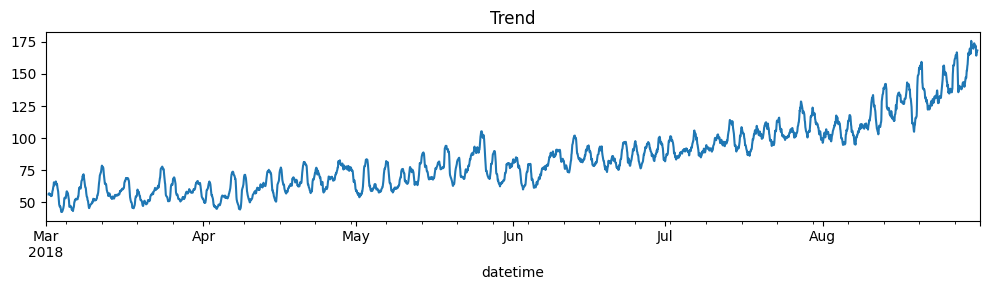

In [8]:
plt.figure(figsize=(10, 3))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.tight_layout()

Видим постепенно растущий тренд от начала к концу наблюдений. Можем предположить, что он связан с годовой сезонностью (рост числа заказов летом). Предположение это проверить не можем, так как данными располагаем лишь за полгода. 

Теперь исследуем тренды и сезонность за последний месяц наблюдений:

In [9]:
decomposed = seasonal_decompose(taxis['num_orders']['2018-08-01':'2018-08-31'])

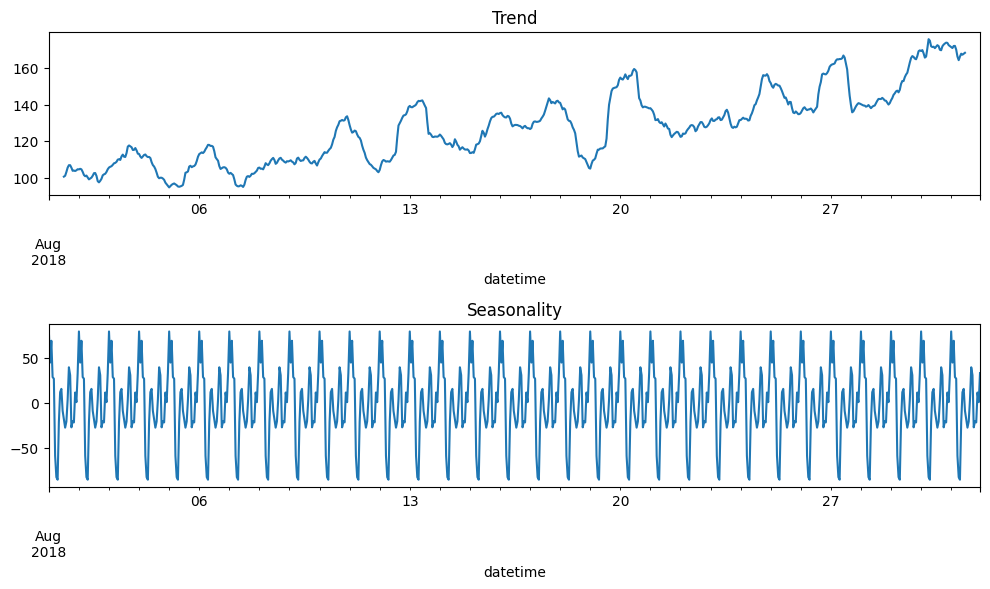

In [10]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

Видим тот же постепенно растущий тренд, на котором также можем наблюдать его некоторый спад по воскресеньям. Кроме того, можем наблюдать суточную сезонность. Рассмотрим ее подробнее:

In [11]:
decomposed = seasonal_decompose(taxis['num_orders']['2018-08-01':'2018-08-02'])

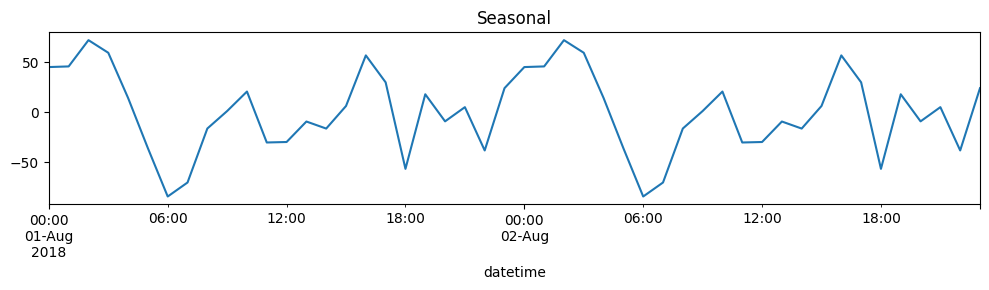

In [12]:
plt.figure(figsize=(10, 3))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.tight_layout()

Видим, что суточный минимум на графике достигается в 6 часов. Можем предположить, что люди до этого времени спят, а после - встают и едут на работу, с чем связан рост числа заказов такси. После 6 происходит постепенный рост с локальным пиком в 10 часов. Вероятно, после этого времени большая часть людей уже оказывается на работе. После спада в районе 12, рост продолжается примерно до 17 часов, после чего в 18 достигается локальный минимум. Скорее всего, в районе 17 люди заказывают такси, чтобы попасть с места работы домой, а дорога в среднем занимает час. Затем рост продолжается до суточного максимума примерно в 2 часа и стремительно падает к суточному минимуму следующего дня. Вероятно, ночной рост связан с тем, что ночью не работает общественный транспорт, поэтому с какого-то времени такси становится единственным вариантом перемещения.  

Создадим функцию для добавления признаков, на вход она принимает датафрейм и название целевого признака:

In [13]:
def make_features(data, target_col):
    new_data = data.copy()
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour
    new_data['lag_1'] = new_data[target_col].shift(1)
    new_data['rolling_mean'] = new_data[target_col].shift().rolling(24).mean()
    return new_data

In [14]:
taxis_new = make_features(taxis, 'num_orders')

## 2. Обучение моделей

Сперва разделим данные на выборки, оставив для тестового набора 10% данных:

In [15]:
train, test = train_test_split(taxis_new, shuffle=False, test_size=0.1)

Кроме того, удалим из обучающего набора строки с пропущенными значениями, которые будут мешать обучению:

In [16]:
train = train.dropna()

Теперь оба этих набора разделим на обучающие и целевой признаки: 

In [17]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

In [18]:
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Также создадим функцию оценки качества моделей, которая будет вычислять необходимую нам метрику - RMSE:

In [19]:
rmse = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

Начнем с обучения модели **линейной регрессии**. Создадим модель:

In [20]:
model = LinearRegression()

Проведем кросс-валидацию с помощью средства TimeSeriesSplit, для чего создадим переменную-сплиттер:

In [21]:
tscv = TimeSeriesSplit()

In [22]:
scores = cross_val_score(model, features_train, target_train, scoring=rmse, cv=tscv)

Выведем результаты кросс-валидации - значения метрик при каждой итерации и их среднее:

In [23]:
print(abs(scores))
print(abs(scores).mean())

[26.96819961 29.42951541 30.38769452 32.2295891  39.95375047]
31.79374982444761


Как видим, при среднем значении RMSE в 31.8, наша модель вполне удовлетворяет потребностям заказчика.

Теперь обучим модель **случайного леса**:

In [24]:
model = RandomForestRegressor()

Проведем гридсерч:

In [25]:
parameters = {'random_state' : [12345],
              'n_estimators': range(80, 301, 20),
              'max_depth': range(5, 36, 5)}

grid = GridSearchCV(model, parameters, scoring=rmse, cv=tscv, verbose=3)

In [26]:
grid.fit(features_train, target_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 1/5] END max_depth=5, n_estimators=80, random_state=12345;, score=-23.241 total time=   0.7s
[CV 2/5] END max_depth=5, n_estimators=80, random_state=12345;, score=-27.227 total time=   0.8s
[CV 3/5] END max_depth=5, n_estimators=80, random_state=12345;, score=-27.913 total time=   1.1s
[CV 4/5] END max_depth=5, n_estimators=80, random_state=12345;, score=-28.583 total time=   1.5s
[CV 5/5] END max_depth=5, n_estimators=80, random_state=12345;, score=-36.317 total time=   1.5s
[CV 1/5] END max_depth=5, n_estimators=100, random_state=12345;, score=-23.264 total time=   0.8s
[CV 2/5] END max_depth=5, n_estimators=100, random_state=12345;, score=-27.242 total time=   0.9s
[CV 3/5] END max_depth=5, n_estimators=100, random_state=12345;, score=-27.804 total time=   1.0s
[CV 4/5] END max_depth=5, n_estimators=100, random_state=12345;, score=-28.646 total time=   1.2s
[CV 5/5] END max_depth=5, n_estimators=100, random_state=1234

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(5, 36, 5),
                         'n_estimators': range(80, 301, 20),
                         'random_state': [12345]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=3)

Выведем результаты гридсерча - параметры лучшей модели и ее средний результат при кросс-валидации:

In [27]:
print(grid.best_params_)
print(abs(grid.best_score_))

{'max_depth': 30, 'n_estimators': 220, 'random_state': 12345}
25.433555633679056


Параметры лучшей модели - max_depth: 30, и n_estimators: 220. Средний результат модели с этими параметрами при кросс-валидации - 25.4, что удовлетворяет потребностям заказчика и превосходит результат модели линейной регрессии. 

Теперь обучим модель **LGBMRegressor** из библиотеки **LightGBM**:

In [28]:
model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    objective='regression',
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=None
)

Проведем кросс-валидацию нашей модели:

In [29]:
scores = cross_val_score(model, features_train, target_train, scoring=rmse, cv=tscv)

Получим результаты работы модели на каждом шаге кросс-валидации и их среднее:

In [30]:
print(abs(scores))
print(abs(scores).mean())

[22.8547581  24.07500665 23.87623927 25.19929752 30.19764373]
25.240589055087934


Видим, что модель уже показывает лучший по сравнению с моделью случайного леса результат - RMSE равно 25.2. Проведем гридсерч по нескольким параметрам:

In [31]:
parameters = {
              'max_depth': range(10, 31, 10),
              'learning_rate': [0.1, 0.2],
              'n_estimators': range(40, 201, 40)
}

grid = GridSearchCV(model, parameters, scoring=rmse, cv=tscv, verbose=3)

In [32]:
grid.fit(features_train, target_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END learning_rate=0.1, max_depth=10, n_estimators=40;, score=-22.549 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=10, n_estimators=40;, score=-23.748 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=10, n_estimators=40;, score=-23.657 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=10, n_estimators=40;, score=-24.859 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=10, n_estimators=40;, score=-31.738 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=10, n_estimators=80;, score=-22.790 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=10, n_estimators=80;, score=-23.990 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=10, n_estimators=80;, score=-23.578 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=10, n_estimators=80;, score=-24.923 total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=10, n_estimators=80;, s

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(objective='regression'),
             param_grid={'learning_rate': [0.1, 0.2],
                         'max_depth': range(10, 31, 10),
                         'n_estimators': range(40, 201, 40)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=3)

Получим лучшие параметры для модели и усредненный результат кросс-валидации при их использовании:

In [33]:
print(grid.best_params_)
print(abs(grid.best_score_))

{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 40}
25.11117285854839


Лучшими значениями параметров для модели оказались max_depth: 10, learning_rate: 0.2, n_estimators: 40. RMSE модели оказалось равным 25.1 - лучший результат по итогам обучения. Выберем эту модель для **проверки на тестовом наборе**.

Создадим новую модель, учитывая результаты гридсерча:

In [34]:
model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=10,
    learning_rate=0.2,
    n_estimators=40,
    objective='regression',
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=None
)

Обучим ее на тренировочной выборке:

In [35]:
model.fit(features_train, target_train)

LGBMRegressor(learning_rate=0.2, max_depth=10, n_estimators=40,
              objective='regression')

Теперь предскажем тестовые данные:

In [36]:
target_predicted = model.predict(features_test)

Посчитаем метрику rmse:

In [37]:
res = mean_squared_error(target_test, target_predicted, squared=False)
res

44.26856253760921

На тестовой выборке получили значение метрики RMSE в 44.3, что укладывается в указанный заказчиком порог, равный 48. Обучение можем признать успешным. Отметим, что значение метрики в 1.8 раза превосходит значение во время кросс-валидации. Вероятно, с помощью корректировки признаков и более точного подбора гиперпараметров можно получить и лучший результат.

Для визуальной оценки предсказаний выведем график, показывающий значения предсказаний и истинные значения за несколько дней. Сперва создадим новую таблицу с соответствующими данными:

In [38]:
y_true = target_test.copy()
y_pred = target_predicted.copy()

In [39]:
d = {'y_true': y_true.values, 'y_pred': y_pred}

In [40]:
pred_eval_table = pd.DataFrame(data=d, index=y_true.index)

Теперь выведем нужный нам график за все время и за несколько дней (3 суток с 20 по 22 августа), чтобы лучше увидеть суточную динамику:

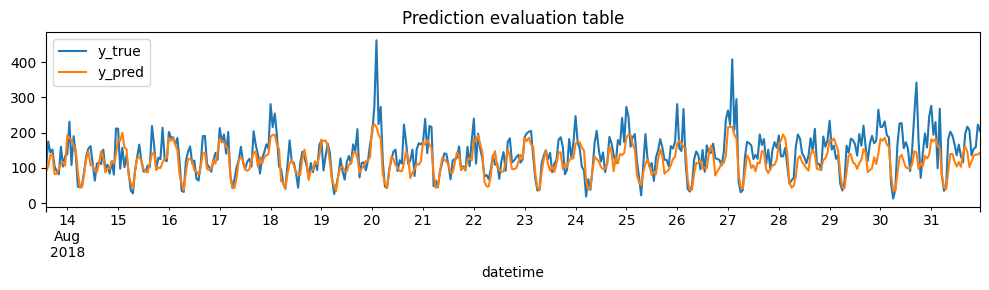

In [41]:
plt.figure(figsize=(10, 3))
pred_eval_table.plot(ax=plt.gca())
plt.title('Prediction evaluation table')
plt.tight_layout()

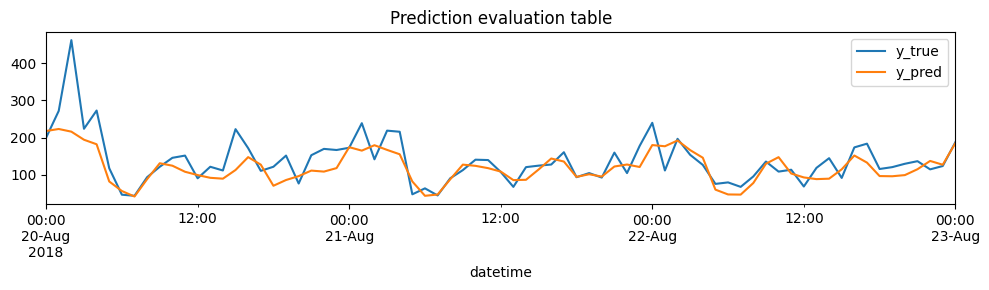

In [42]:
plt.figure(figsize=(10, 3))
pred_eval_table['2018-08-20':'2018-08-23 00:00:00'].plot(ax=plt.gca())
plt.title('Prediction evaluation table')
plt.tight_layout()

Кроме того, для понимания общей ситуации, выведем основные статистики по всей таблице:

In [43]:
pred_eval_table.describe(percentiles=[.5])

,y_true,y_pred
count,442.000000,442.000000
mean,139.556561,119.134646
std,58.615955,39.507185
min,13.000000,34.699649
50%,135.000000,115.915470
max,462.000000,223.436835


Заметим, что предсказания имеют тенденцию **недооценивать** реальные значения, особенно в локальных максимумах. Это наблюдение подтверждают и статистические данные - и **среднее и медиана у предсказания ниже, чем у истинных данных**. Кроме того видим, что максимальное значение реальных данных в 2 раза выше, чем у предсказанных, минимальное значение также отличется в 2 раза от предсказания модели. По графику можем сказать, что **максимум достигается 20го августа, а минимум - 30го.** Можем сказать (также беря во внимание и стандартное отклонение), что **предсказания модели представляют из себя** как бы **усредненные, сглаженные реальные данные**.<br>

**Cамая заметная недооценка происходит**, как кажется, **в районе полуночи**, что особенно заметно как раз 20го числа (также 27го и 18го). Однако, **модель** достаточно **хорошо себя показывает в промежутке примерно с 6 до 12 утра**, где визуальный разрыв с реальными значениями минимален.